import torch
from torch import nn

In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from siren_pytorch import Sine

In [2]:
%matplotlib inline

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cpu'

In [5]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.layers = nn.Sequential(nn.Linear(2, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(),) 
                                    #nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.ReLU(),
                                    #nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid())
        
        self.dist_head = nn.Sequential(nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 2), nn.SELU())
        #self.reg_head = nn.Sequential(nn.Linear(5, 5), nn.BatchNorm1d(5), nn.Sigmoid(), nn.Linear(5, 1), nn.Sigmoid())
        
    def forward(self, x):
        x = self.layers(x)
        return self.dist_head(x)#, self.reg_head(x)

In [6]:
data = torch.rand((100, 100), device=device)
data[data < 0.99] = 0
data *= 1000

In [7]:
data[10:45, 0:15] = torch.rand((35, 15), device=device) * 1000
data[30:90, 30:85] = torch.rand((60, 55), device=device) * 1000
data[85:95, 85:95] = torch.rand((10, 10), device=device) * 1000
# data /= data.max()

In [24]:
epochs = 20000
start_point = torch.tensor(0.0, device=device)
end_point = torch.tensor(1.0, device=device)

model = Regressor()
reg_loss = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
# optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)
model = model.to(device)

w =  data.shape[1]
delta = 1 / data.shape[0]
t = torch.linspace(start=0, end=1, steps=data.shape[0], device=device)
t = torch.cat([t[..., None], t[..., None]], dim=1)
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    #output_d, pred_z = model(t)
    output_d = model(t)
    dis_norm =  torch.distributions.Normal(output_d[:, 0], output_d[:, 1])
    s = dis_norm.rsample()
    output_y = s
    
    broad_loss = torch.abs(output_y[0] - start_point) + torch.abs(output_y[-1] - end_point)
    delta_y = output_y[1:] - output_y[:-1]
    
    index = torch.tensor(output_y.clone().detach().clamp(0, 1 - 1 / w) * w, requires_grad=False, dtype=torch.long, device=device)
    z = torch.gather(data, 1, index[..., None])
#     delta_z = pred_z[1:] - pred_z[:-1]
    delta_z = z[1:] - z[:-1]
    
    length = (1 + (delta_y / delta) ** 2 + (delta_z / delta) ** 2).mean() * delta
    loss = 100 * broad_loss + length# + torch.abs(delta_y * delta_z).mean()# + reg_loss(pred_z, z)
    
    loss.backward()
    t[:, 1] = s.detach()

    loss_history.append(loss.item())
    optimizer.step()


/home/robo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


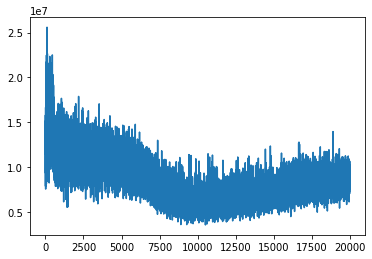

In [25]:
plt.plot(loss_history)

In [26]:
output = model(t)
output_y = output[:, 0]
output_y[0], output_y[-1]

(tensor(-0.0008, grad_fn=<SelectBackward>),
 tensor(1.0007, grad_fn=<SelectBackward>))

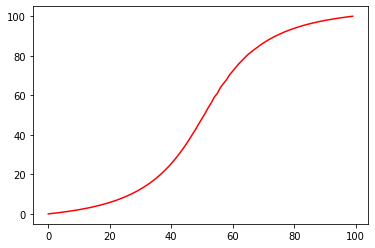

In [27]:
plt.plot(output_y.detach().cpu().numpy() * w, 'r')

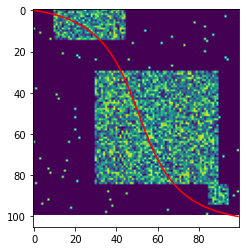

In [28]:
plt.imshow(data.cpu().numpy().transpose(1, 0))
plt.plot(output_y.detach().cpu().numpy() * w, 'r')

In [29]:
plt.close()

In [30]:
dis_norm.mean, dis_norm.stddev

(tensor([3.3649e-04, 2.1094e-03, 3.8027e-03, 5.5839e-03, 7.6021e-03, 9.6185e-03,
         1.1845e-02, 1.4002e-02, 1.6383e-02, 1.8933e-02, 2.1569e-02, 2.4337e-02,
         2.7291e-02, 3.0428e-02, 3.3752e-02, 3.7272e-02, 4.0983e-02, 4.4920e-02,
         4.9089e-02, 5.3517e-02, 5.8228e-02, 6.3174e-02, 6.8498e-02, 7.4177e-02,
         8.0167e-02, 8.6522e-02, 9.3461e-02, 1.0067e-01, 1.0846e-01, 1.1668e-01,
         1.2554e-01, 1.3502e-01, 1.4507e-01, 1.5578e-01, 1.6735e-01, 1.7964e-01,
         1.9281e-01, 2.0682e-01, 2.2191e-01, 2.3782e-01, 2.5467e-01, 2.7317e-01,
         2.9217e-01, 3.1254e-01, 3.3395e-01, 3.5653e-01, 3.7920e-01, 4.0654e-01,
         4.3140e-01, 4.5687e-01, 4.8517e-01, 5.1120e-01, 5.3620e-01, 5.6365e-01,
         5.9033e-01, 6.1416e-01, 6.3824e-01, 6.6092e-01, 6.8127e-01, 7.0558e-01,
         7.2641e-01, 7.4069e-01, 7.5964e-01, 7.7854e-01, 7.9343e-01, 8.0772e-01,
         8.1993e-01, 8.3231e-01, 8.4466e-01, 8.5456e-01, 8.6636e-01, 8.7657e-01,
         8.8477e-01, 8.9435e

In [31]:
length ** 0.5

tensor(3187.5442, grad_fn=<PowBackward0>)